# HOMEWORK 

Web Scraping Exercise
1. Introduction and Planning
Objective:
The goal of this exercise is to build a web scraper that collects data from a chosen website. You will learn how to send HTTP requests, parse HTML content, extract relevant data, and store it in a structured format.

Tasks:
Identify the data you want to scrape.
Choose the target website(s).
Plan the structure of your project.
Example:
For this exercise, we will scrape job listings from Indeed.com. We will extract job titles, company names, locations, and job descriptions.

2. Understanding the Target Website
Objective:
Analyze the structure of the web pages to be scraped.

Tasks:
Inspect the target website using browser developer tools.
Identify the HTML elements that contain the desired data.
Instructions:
Open your browser and navigate to the target website (e.g., Indeed.com).
Right-click on the webpage and select "Inspect" or press Ctrl+Shift+I.
Use the developer tools to explore the HTML structure of the webpage.
Identify the tags and classes of the elements that contain the job titles, company names, locations, and descriptions.
3. Writing the Scraper
Objective:
Develop the code to scrape data from the target website.

Tasks:
Send HTTP requests to the target website.
Parse the HTML content and extract the required data.
Handle pagination to scrape data from multiple pages.
Implement error handling.

El código siguiente fue ejecutado en formato py el archivo web-scraping.py

In [2]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np
import multiprocessing as mp

In [ ]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np
import multiprocessing as mp

def fetch_html_content(url, headers, timeout=10):
    try:
        response = requests.get(url, headers=headers, timeout=timeout)
        return BeautifulSoup(response.text, "html.parser")
    except requests.Timeout:
        print(f"Timeout occurred for URL: {url}")
    except requests.RequestException as e:
        print(f"Request failed for URL: {url} with exception: {e}")
    return None

def extract_links(url_elements):
    all_links = []
    for link_item in url_elements.find_all("li", class_="comp mntl-link-list__item"):
        anchor_tag = link_item.find("a", href=True)
        if anchor_tag:
            all_links.append(anchor_tag['href'])
    return all_links

def get_links_from_page(page_elements):
    all_links = []
    for link_item in page_elements.find_all("a", class_="comp mntl-card-list-items mntl-document-card mntl-card card card--no-image"):
        if link_item.has_attr('href'):
            all_links.append(link_item['href'])
    return all_links

def get_title(soup):
    return soup.find("title").text if soup else np.nan

def get_recipe_description(soup):
    description = soup.find("p", class_="article-subheading type--dog")
    return description.text if description else np.nan

def get_recipe_ingredients(soup):
    if not soup:
        return np.nan
    ingredient_text = ''
    for item in soup.find_all("li", class_="mm-recipes-structured-ingredients__list-item"):
        ingredient_text += item.text.strip() + '\n'
    return ingredient_text

def get_recipe_steps(soup):
    if not soup:
        return np.nan
    step_text = ''
    for step_item in soup.find_all("li", class_="comp mntl-sc-block mntl-sc-block-startgroup mntl-sc-block-group--LI"):
        for tag in step_item.find_all(["figure", "div"]):
            tag.decompose()
        step_text += step_item.text.strip() + '\n'
    return step_text

def process_recipe(args):
    url, headers = args
    soup = fetch_html_content(url, headers)
    return {
        'Title': get_title(soup),
        'Description': get_recipe_description(soup),
        'Ingredients': get_recipe_ingredients(soup),
        'Steps': get_recipe_steps(soup)
    }

if __name__ == "__main__":
    headers = {
        "User-Agent": "My App"
    }

    # Read the initial HTML file
    with open(r"C:\RI-deberes\ir24a\2DO-BIMESTRE\web scrapping\Recipes A-Z _ Allrecipes.com.html", "r", encoding="utf-8") as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, "html.parser")

    # Extract initial links
    links_html = extract_links(soup)

    # Fetch HTML content for initial links
    with mp.Pool(processes=mp.cpu_count()) as pool:
        recipe_links = list(tqdm(pool.starmap(fetch_html_content, [(url, headers) for url in links_html]), total=len(links_html), desc="Fetching initial links"))

    # Get links from each recipe page
    links_per_recipe_page = [get_links_from_page(link) for link in recipe_links if link]

    # Combine all links
    all_links = [link for links_in_page in links_per_recipe_page for link in links_in_page]

    print(f"Total recipes to process: {len(all_links)}")

    # Process all recipes in parallel
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_recipe, [(url, headers) for url in all_links]), total=len(all_links), desc="Processing recipes"))

    # Create DataFrame
    recipe_df = pd.DataFrame(results)

    # Save to CSV
    recipe_df.to_csv('AllRecipes.csv', index=True)
    print("Data saved to AllRecipes.csv")

RESULTADO DE LA EJECUCIÓN

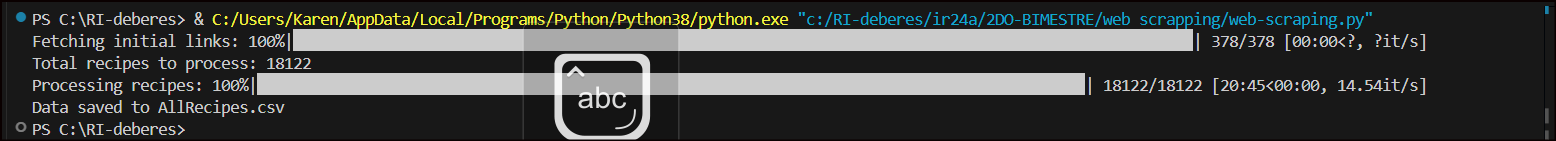

LECTURA DEL ARCHIVO QUE SE GUARDO EN FORMATO CSV

In [3]:
df = pd.read_csv(r"C:\RI-deberes\AllRecipes.csv")
df

,Unnamed: 0,Title,Description,Ingredients,Steps
0,0,Air Fryer Buffalo Wings Recipe,These crispy air fryer Buffalo wings are seaso...,2 teaspoons sea salt\n1 teaspoon garlic powder...,Preheat an air fryer to 380 degrees F (190 deg...
1,1,Air Fryer Smashed Potatoes Recipe,"These golden, crispy air fryer smashed potatoe...",8 ounces baby gold potatoes\n1 tablespoon melt...,Preheat an air fryer to 400 degrees F (200 deg...
2,2,Air Fryer Quesadillas Recipe,These air fryer quesadillas are golden and cri...,2 flour tortillas\n1/2 cup shredded cheese\nno...,"Heat tortillas in the microwave until pliable,..."
3,3,Air Fryer Truffle Polenta Fries Recipe,"These air fryer truffle polenta fries, flavore...",1 (18 ounce) tube prepared polenta\n1 1/2 tabl...,Preheat an air fryer to 400 degrees F (200 deg...
4,4,Air Fryer Firecracker Salmon Bites Recipe,These air fryer firecracker salmon bites get a...,1/4 cup balsamic vinegar\n1/4 cup brown sugar\...,"Combine balsamic vinegar, brown sugar, oil, so..."
...,...,...,...,...,...
18117,18117,Vegan Zucchini Banana Bread Recipe,"This yummy, moist, rich zucchini banana bread ...",3 cups all-purpose flour\n1 teaspoon salt\n1 t...,Preheat the oven to 325 degrees F (165 degrees...
18118,18118,Zucchini-Raspberry Bread Recipe,It's a simple zucchini nut bread with a splash...,1 ½ cups self-rising flour\n1 teaspoon ground ...,Preheat an oven to 350 degrees F (175 degrees ...
18119,18119,Healthier Mom's Zucchini Bread Recipe,We packed even more zucchini into Mom's wonder...,1 ½ cups all-purpose flour\n1 ½ cups white who...,Preheat oven to 325 degrees F (165 degrees C)....
18120,18120,"Zucchini Bread, Pumpkin Style Recipe","Although I love zucchini bread, I wanted a new...","3 medium zucchini, cut into chunks\n4 ¾ cups a...",Preheat an oven to 350 degrees F (175 degrees ...
